# Dataset VDA
Registrazione delle misure recuperate da SCIA e ISAC. Non sono riuscito a recuperare dati sensati da ARPA (forniscono solo valori interi).

La procedura si articola nei seguenti passaggi:
1. [caricamento dei dati grezzi](#caricamento-da-frammenti) e uniformazione negli schemi esposti sotto;
1. [primo quality check](#quality-check): controllo errori di consistenza nella singola serie e nelle coppie di serie della stessa stazione;
1. [overview disponibilità dati](#overview-disponibilità-dati): plot che mostrano la disponibilità temporale e spaziale di serie;
1. [merging](#merging) del dataset.

## Data model
### Metadati
| station_id | station_name | network | state | lon    | lat    | elevation | dataset_id | original_id |
|------------|--------------|---------|-------|--------|--------|-----------|------------|-------------|
| utf8()     | utf8()       | utf8()  | utf8()|double()|double()| double()  | utf8()     | utf8()      |
| pkey       | obs          | obs     | obs   | obs    | obs    | obs       | fkey       | obs         |

I metadati delle stazioni che non rientrano nelle tabelle elencate vanno in una tabella "extra" collegata tramite "station_id".

### Dati
|series_id|date|value|merged|variable|
|---------|----|-----|------|--------|
|utf8()|date()|double()|bool()|utf8()|
| fkey    |obs | obs | obs  | obs    |

Note:
- `merged` indica se il valore in riga è il risultato di un merge.


In [1]:
dataset_id <- "VDA"
state <- "Valle D'Aosta"


In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(stringr, warn.conflicts = FALSE)
options(repr.plot.width = 9, repr.plot.res = 300)

# source(str_glue("notebooks/integrazioni_regionali/{str_to_lower(state)}/procedures/load_daily.R"))
source(str_glue("notebooks/integrazioni_regionali/vda/procedures/match_taggers.R"))
source("notebooks/integrazioni_regionali/procedure/common_steps.R")
source("notebooks/integrazioni_regionali/procedure/checkpoint.R")
source("notebooks/integrazioni_regionali/procedure/tools.R")
source("src/database/tools.R")
source("src/load/ITA.R")

first_date <- as.Date("2000-01-01")
last_date <- as.Date("2022-12-31")
state_boundaries <- load.italian_boundaries("state") |> filter(shapeName == state)


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



## Caricamento da frammenti
Dati giornalieri come forniti dall'ente, in formato tabella Arrow


## Quality check
Controllo gross errors, dati ripetuti, T_MIN >= T_MAX, serie intere

## Overview disponibilità dati
Grafici che mostrano la disponibilità di serie mese per mese e sul territorio

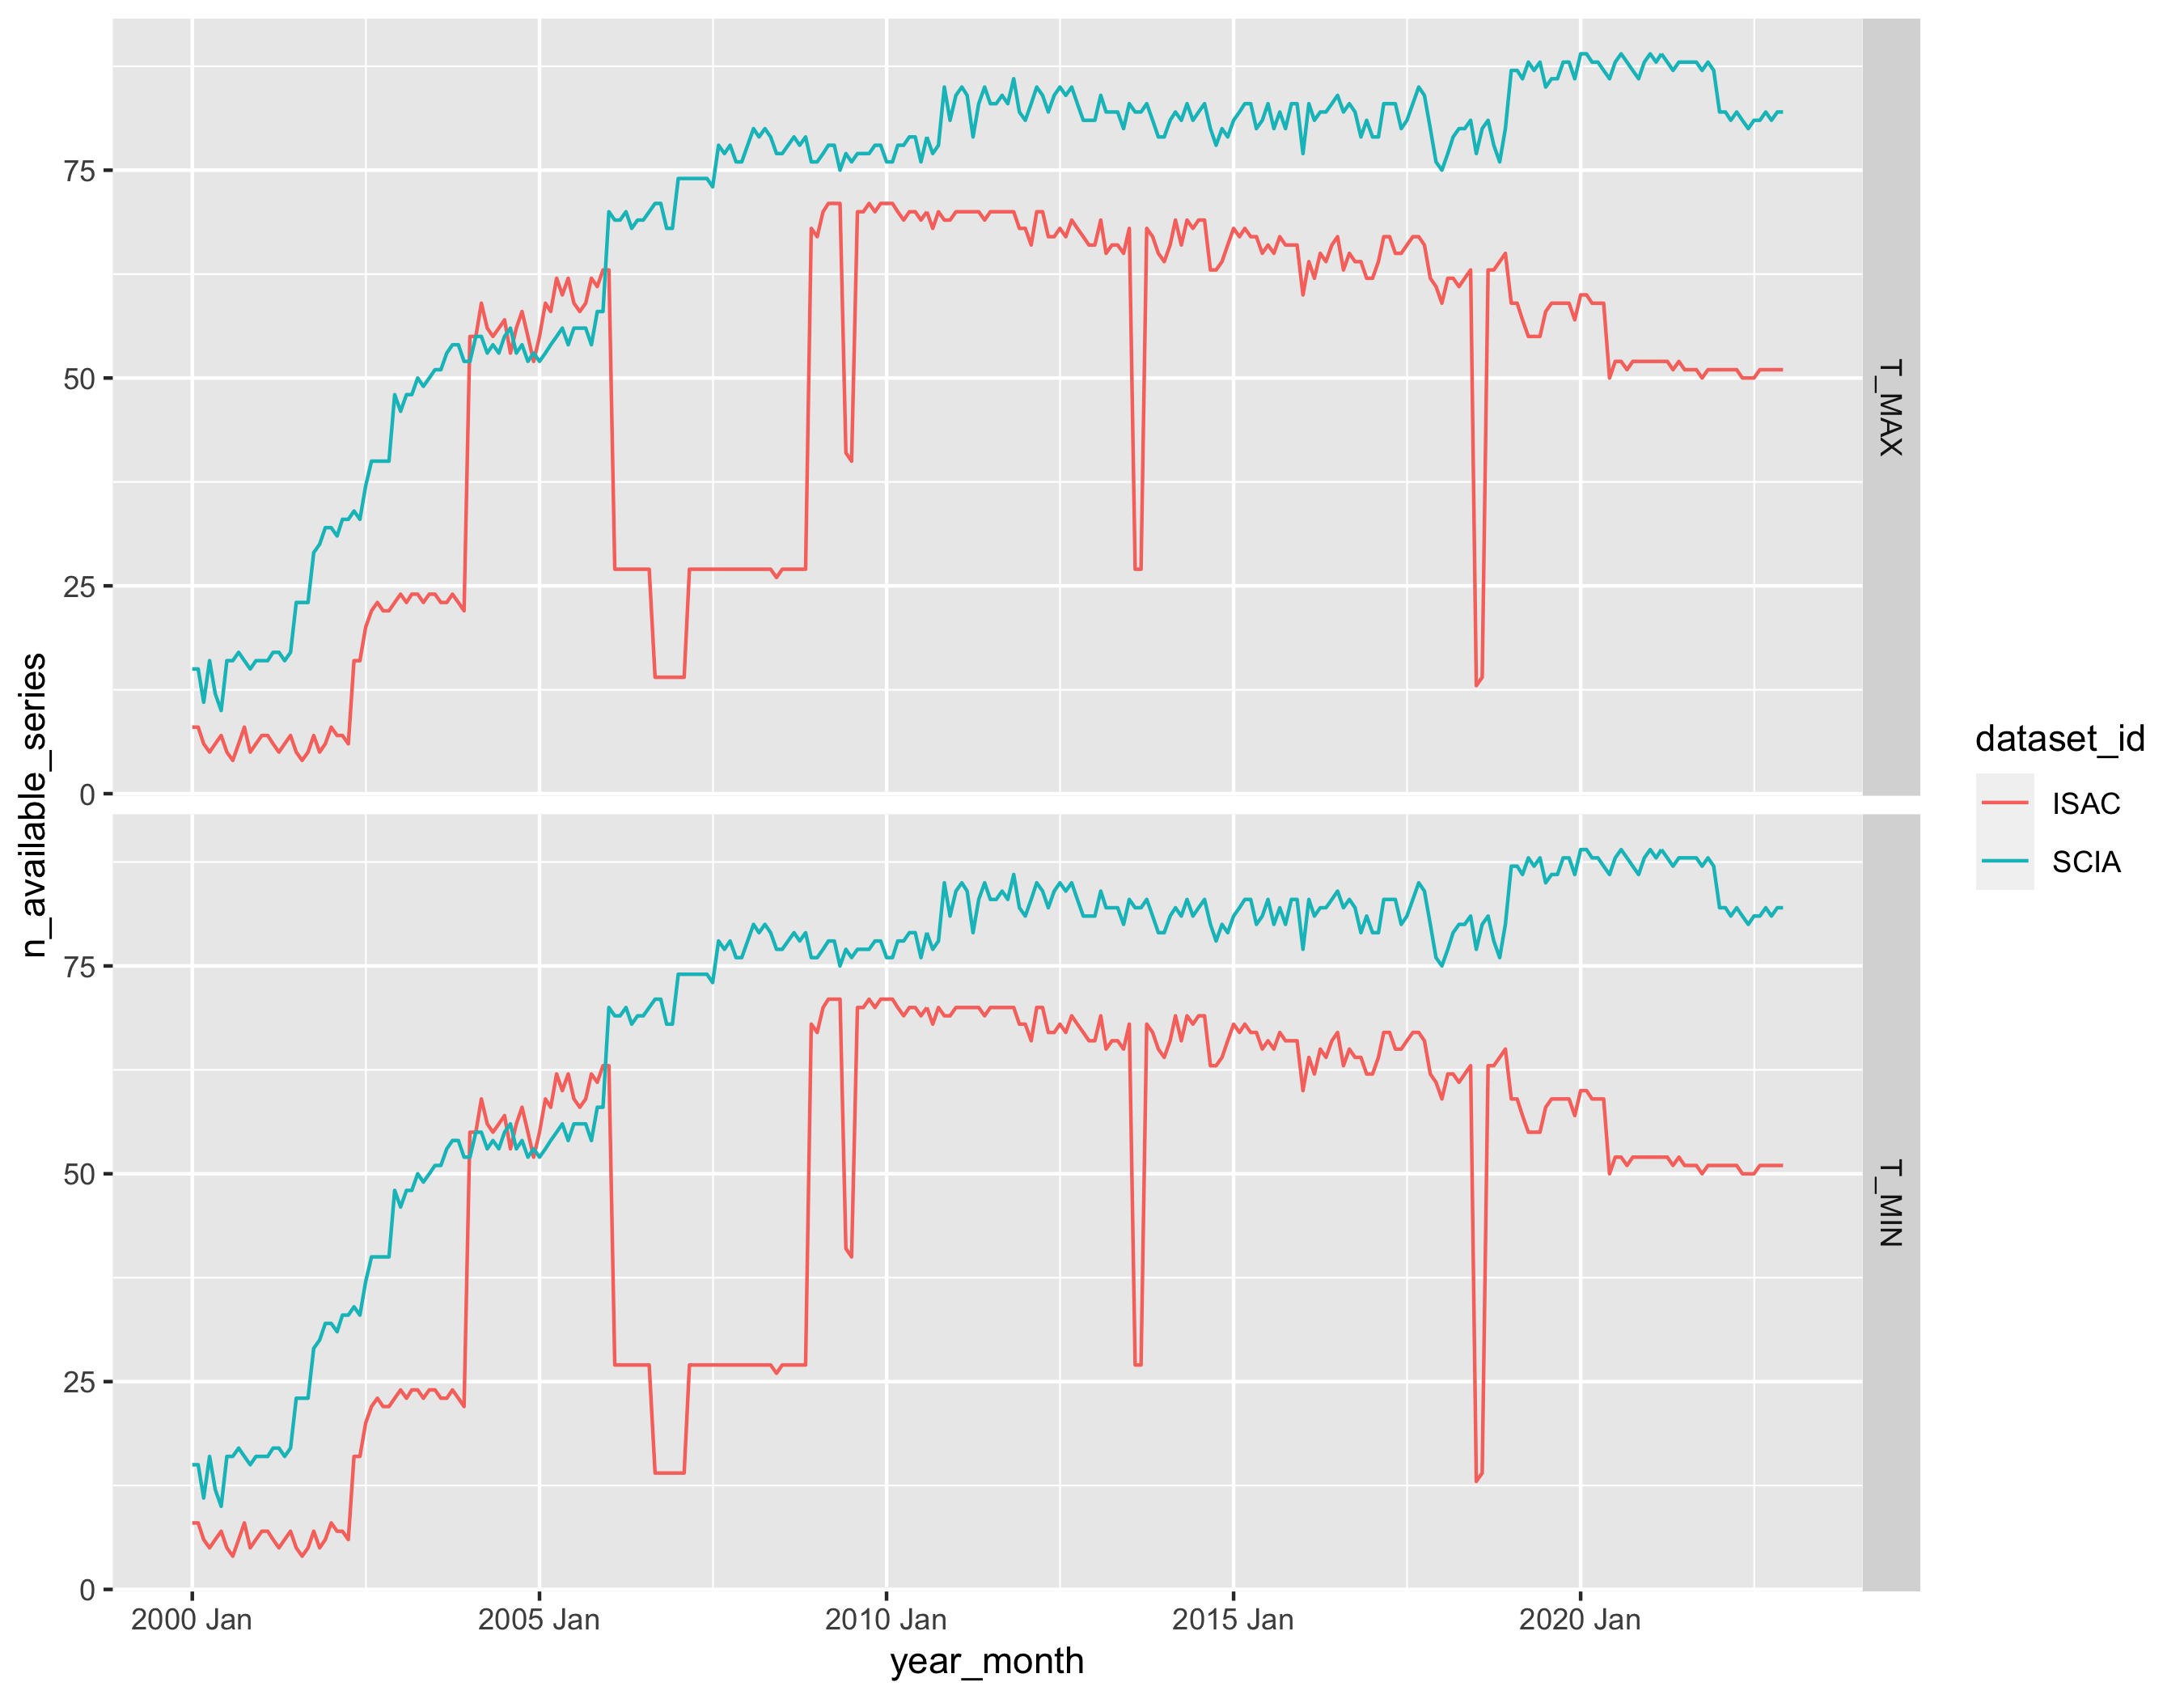

In [3]:
qc_database <- concat_databases(
    open_checkpoint("ISAC", "qc1") |> filter_checkpoint_inside(state_boundaries),
    open_checkpoint("SCIA", "qc1") |> filter_checkpoint_inside(state_boundaries)
)
c(p, ymonthly_avail) %<-% ymonthly_availabilities(qc_database,
    against = NULL,
    start_date = first_date,
    end_date = last_date
)
p


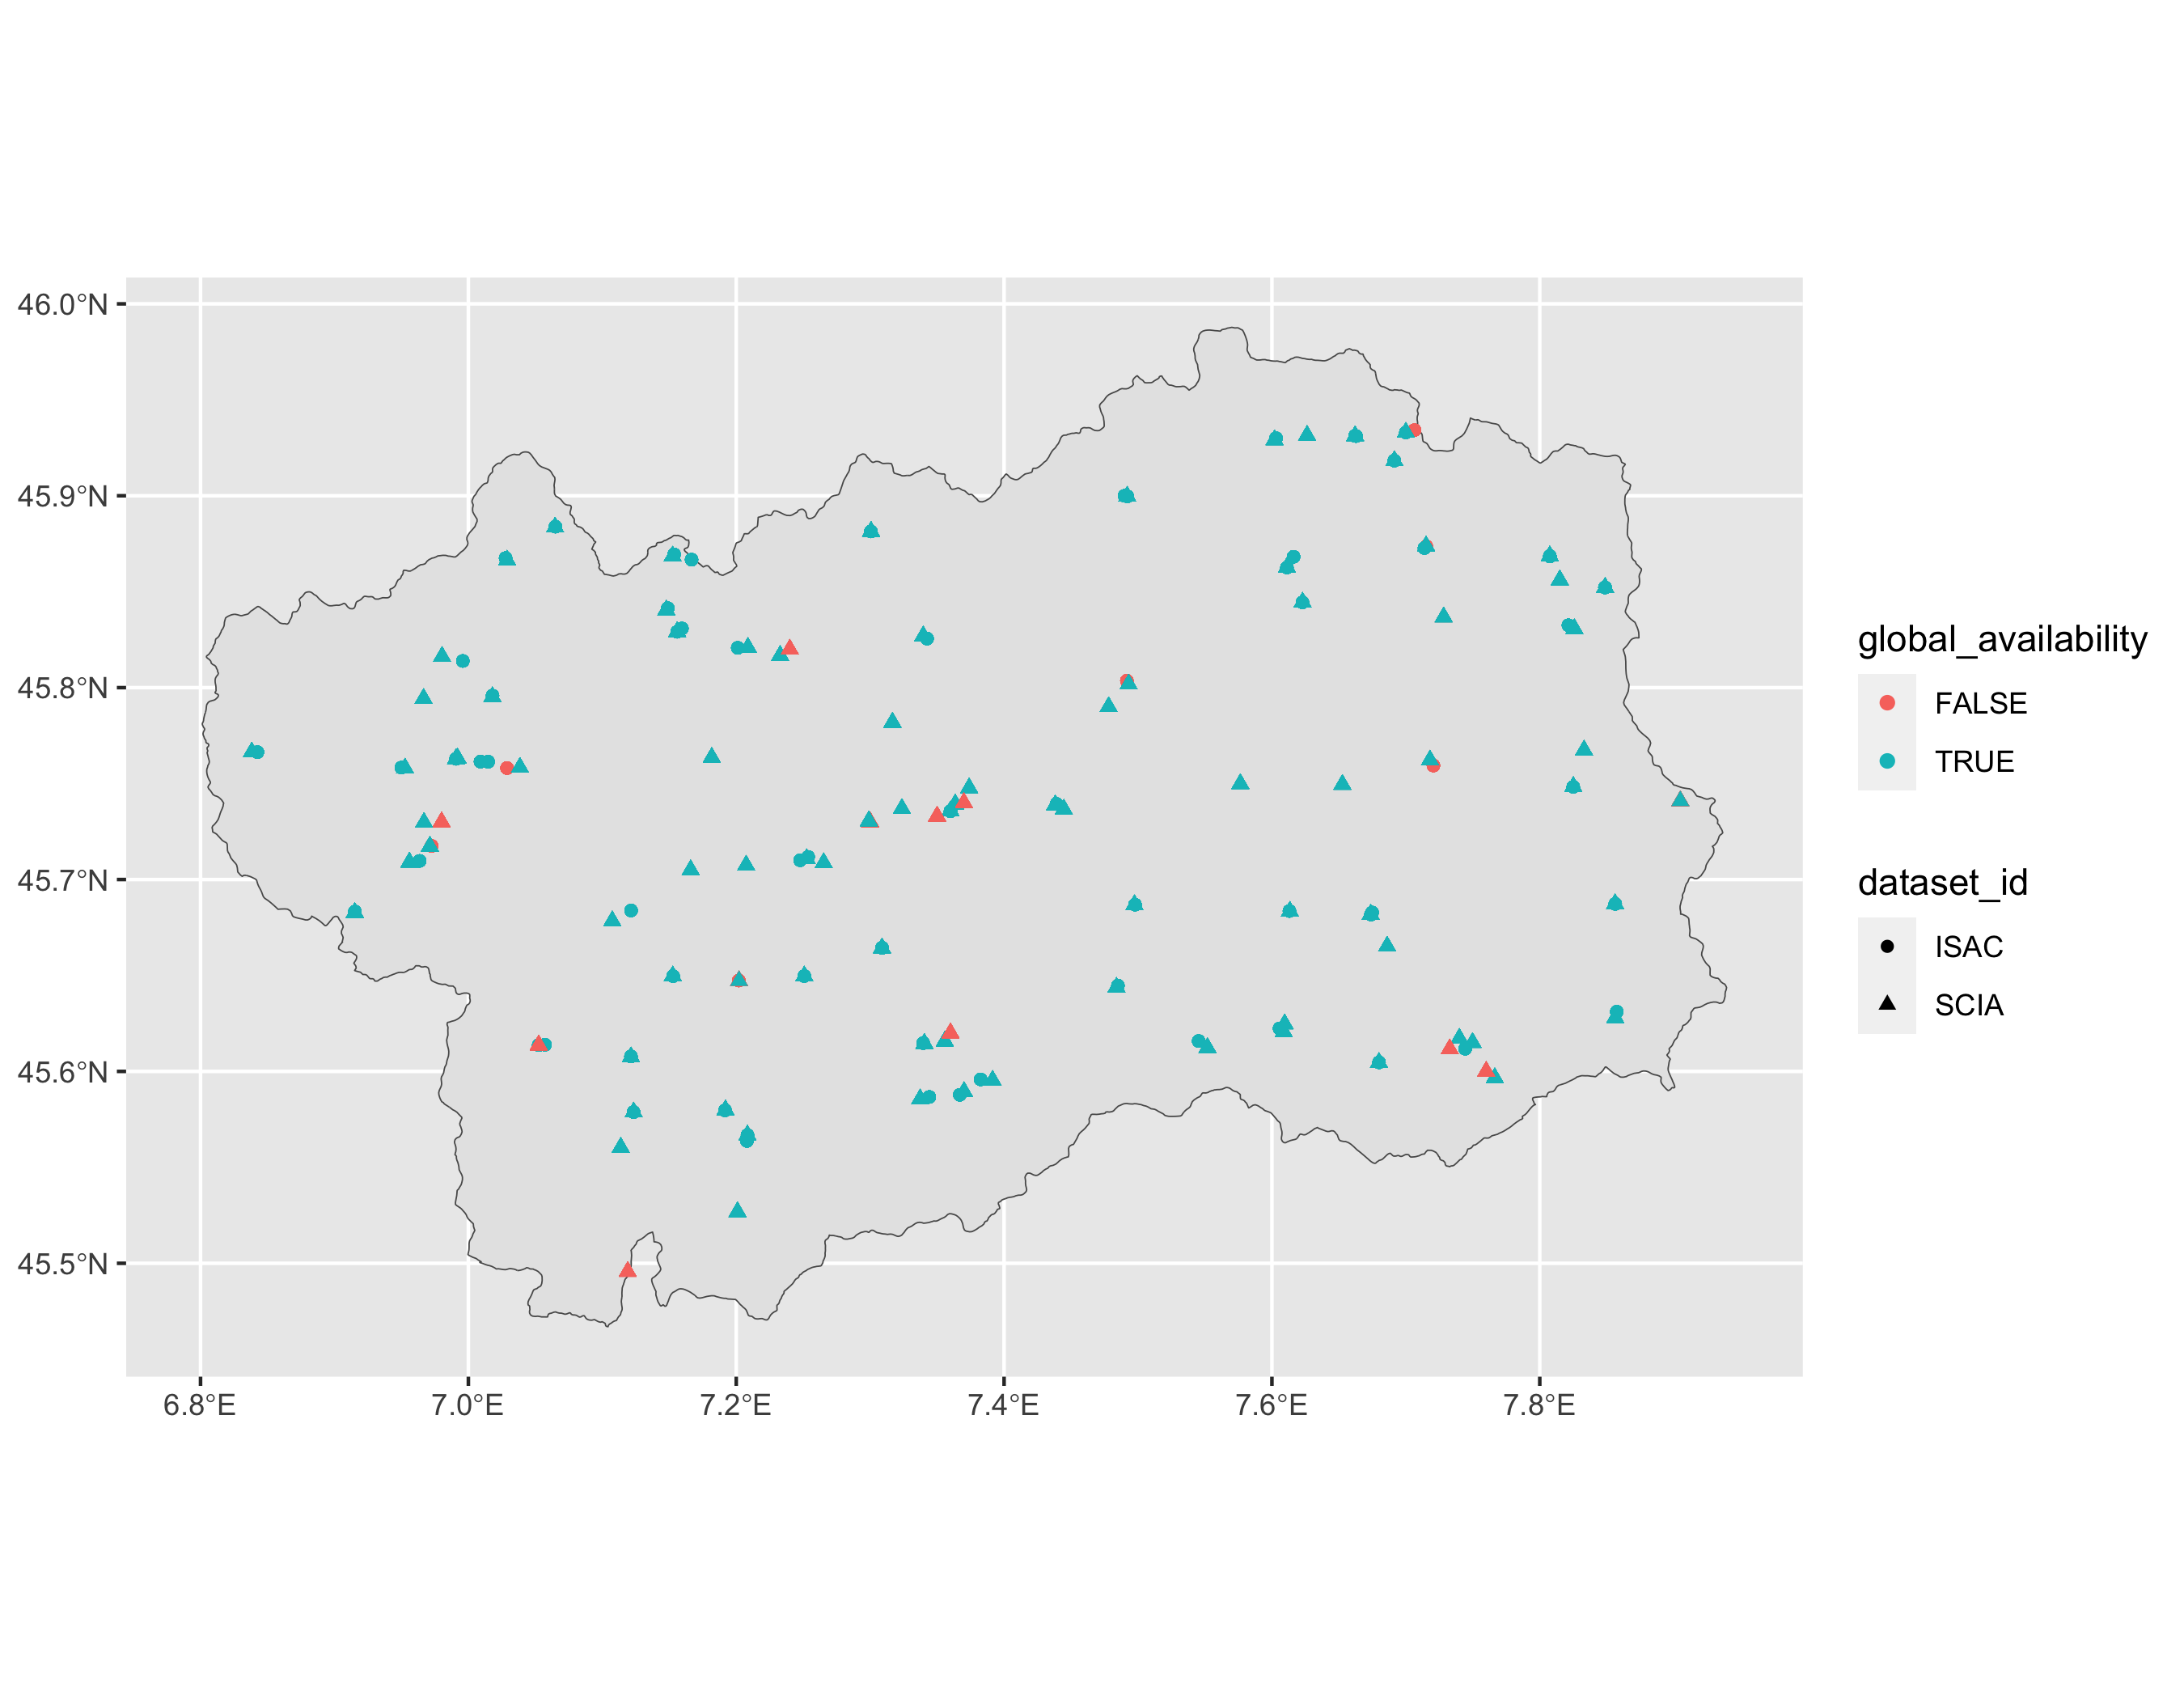

In [4]:
c(p, climats) %<-% spatial_availabilities(ymonthly_avail, qc_database$meta, state_boundaries)
p


In [5]:
rm(qc_database)
rm(ymonthly_avail)
rm(climats)
rm(p)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2064972,110.3,3543512,189.3,NA,3543512,189.3
Vcells,4121130,31.5,79485750,606.5,16384,99357187,758.1


## Merging
Gap-filling con altri dataset

### Match stazioni
Partendo dal file di analisi appena scritto preparo dei filtri che categorizzino il match.

Le possibilità sono:
- `tag_same_station`: il match indica una stessa stazione;
- `tag_unusable`: il match è inutilizzabile;
- `tag_pairable`: il match indica che le stazioni sono utilizzabili per fare gap-filling.

Può essere che un match sia sulla stessa stazione ma che sia inutilizzabile; `tag_unusable` e `tag_pairable` invece si dovrebbero escludere vicendevolmente.

In [6]:
qc_state <- concat_databases(
    open_checkpoint("ISAC", "qc1") |> filter_checkpoint_inside(state_boundaries),
    open_checkpoint("SCIA", "qc1") |> filter_checkpoint_inside(state_boundaries)
)
analysis_results <- perform_analysis_symmetric(
    qc_state,
    dist_km = 6,
    first_date,
    last_date,
    file.path("vda", "analysis.xlsx"),
    default_symmetric_filter,
    priority_table = NULL
)

rm(qc_state)
gc()


Data prepared. Launching analysis...

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2180570,116.5,5165330,275.9,NA,5165330,275.9
Vcells,7309677,55.8,237324446,1810.7,16384,296464181,2261.9


In [7]:
analysis_results <- tag_analysis(analysis_results, list("same_station" = tag_same_station, "unusable" = tag_unusable))
analysis_results$analysis |>
        group_by(same_station, unusable) |>
        tally()
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.x) |>
        tally() |>
        filter(n != 2L & n != 4L)
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.y) |>
        tally() |>
        filter(n != 2L)


same_station,unusable,n
<lgl>,<lgl>,<int>
FALSE,FALSE,151
FALSE,TRUE,771
TRUE,FALSE,171
TRUE,TRUE,17


station_id.x,n
<chr>,<int>
39469c0bfd51b6a43a5a68899b21c39a,1
39542858d7868ffa4f76c51fedaf0e4b,1
4c0a3abeaf645966ded1dca89c2a9c98,1
4f3bf1eecce2f0b9732eb29c1b8b4130,1
5d6efabb85a8755d48eddd86606f9522,1
6578f7a09c9b28f4e541d44d78632a22,1
707cb3ebe72c127f30783f15637389bf,1
745943eb0cfa2913dab3fef1669c963f,3
748bc17d7f51037e3bb56162a8c90a0b,1


station_id.y,n
<chr>,<int>
0564f6bcba1f698f4c24340a57645f40,4
273c098b40012ea0d08320a1d1801524,4
39469c0bfd51b6a43a5a68899b21c39a,1
39542858d7868ffa4f76c51fedaf0e4b,1
434e65f82337a64124148fccfea4936c,4
4c0a3abeaf645966ded1dca89c2a9c98,3
4f3bf1eecce2f0b9732eb29c1b8b4130,3
5d6efabb85a8755d48eddd86606f9522,3
5fb2cb97baed1e8a816acfbe69d90f16,4


In [8]:
combination_results <- build_combined_database(analysis_results, use_corrections = TRUE, checks = TRUE, test_bounds = 1)
checkpoint_database(combination_results$database, dataset_id, "scia_merged")
save_match_list(combination_results$match_list, dataset_id, "scia_merged")


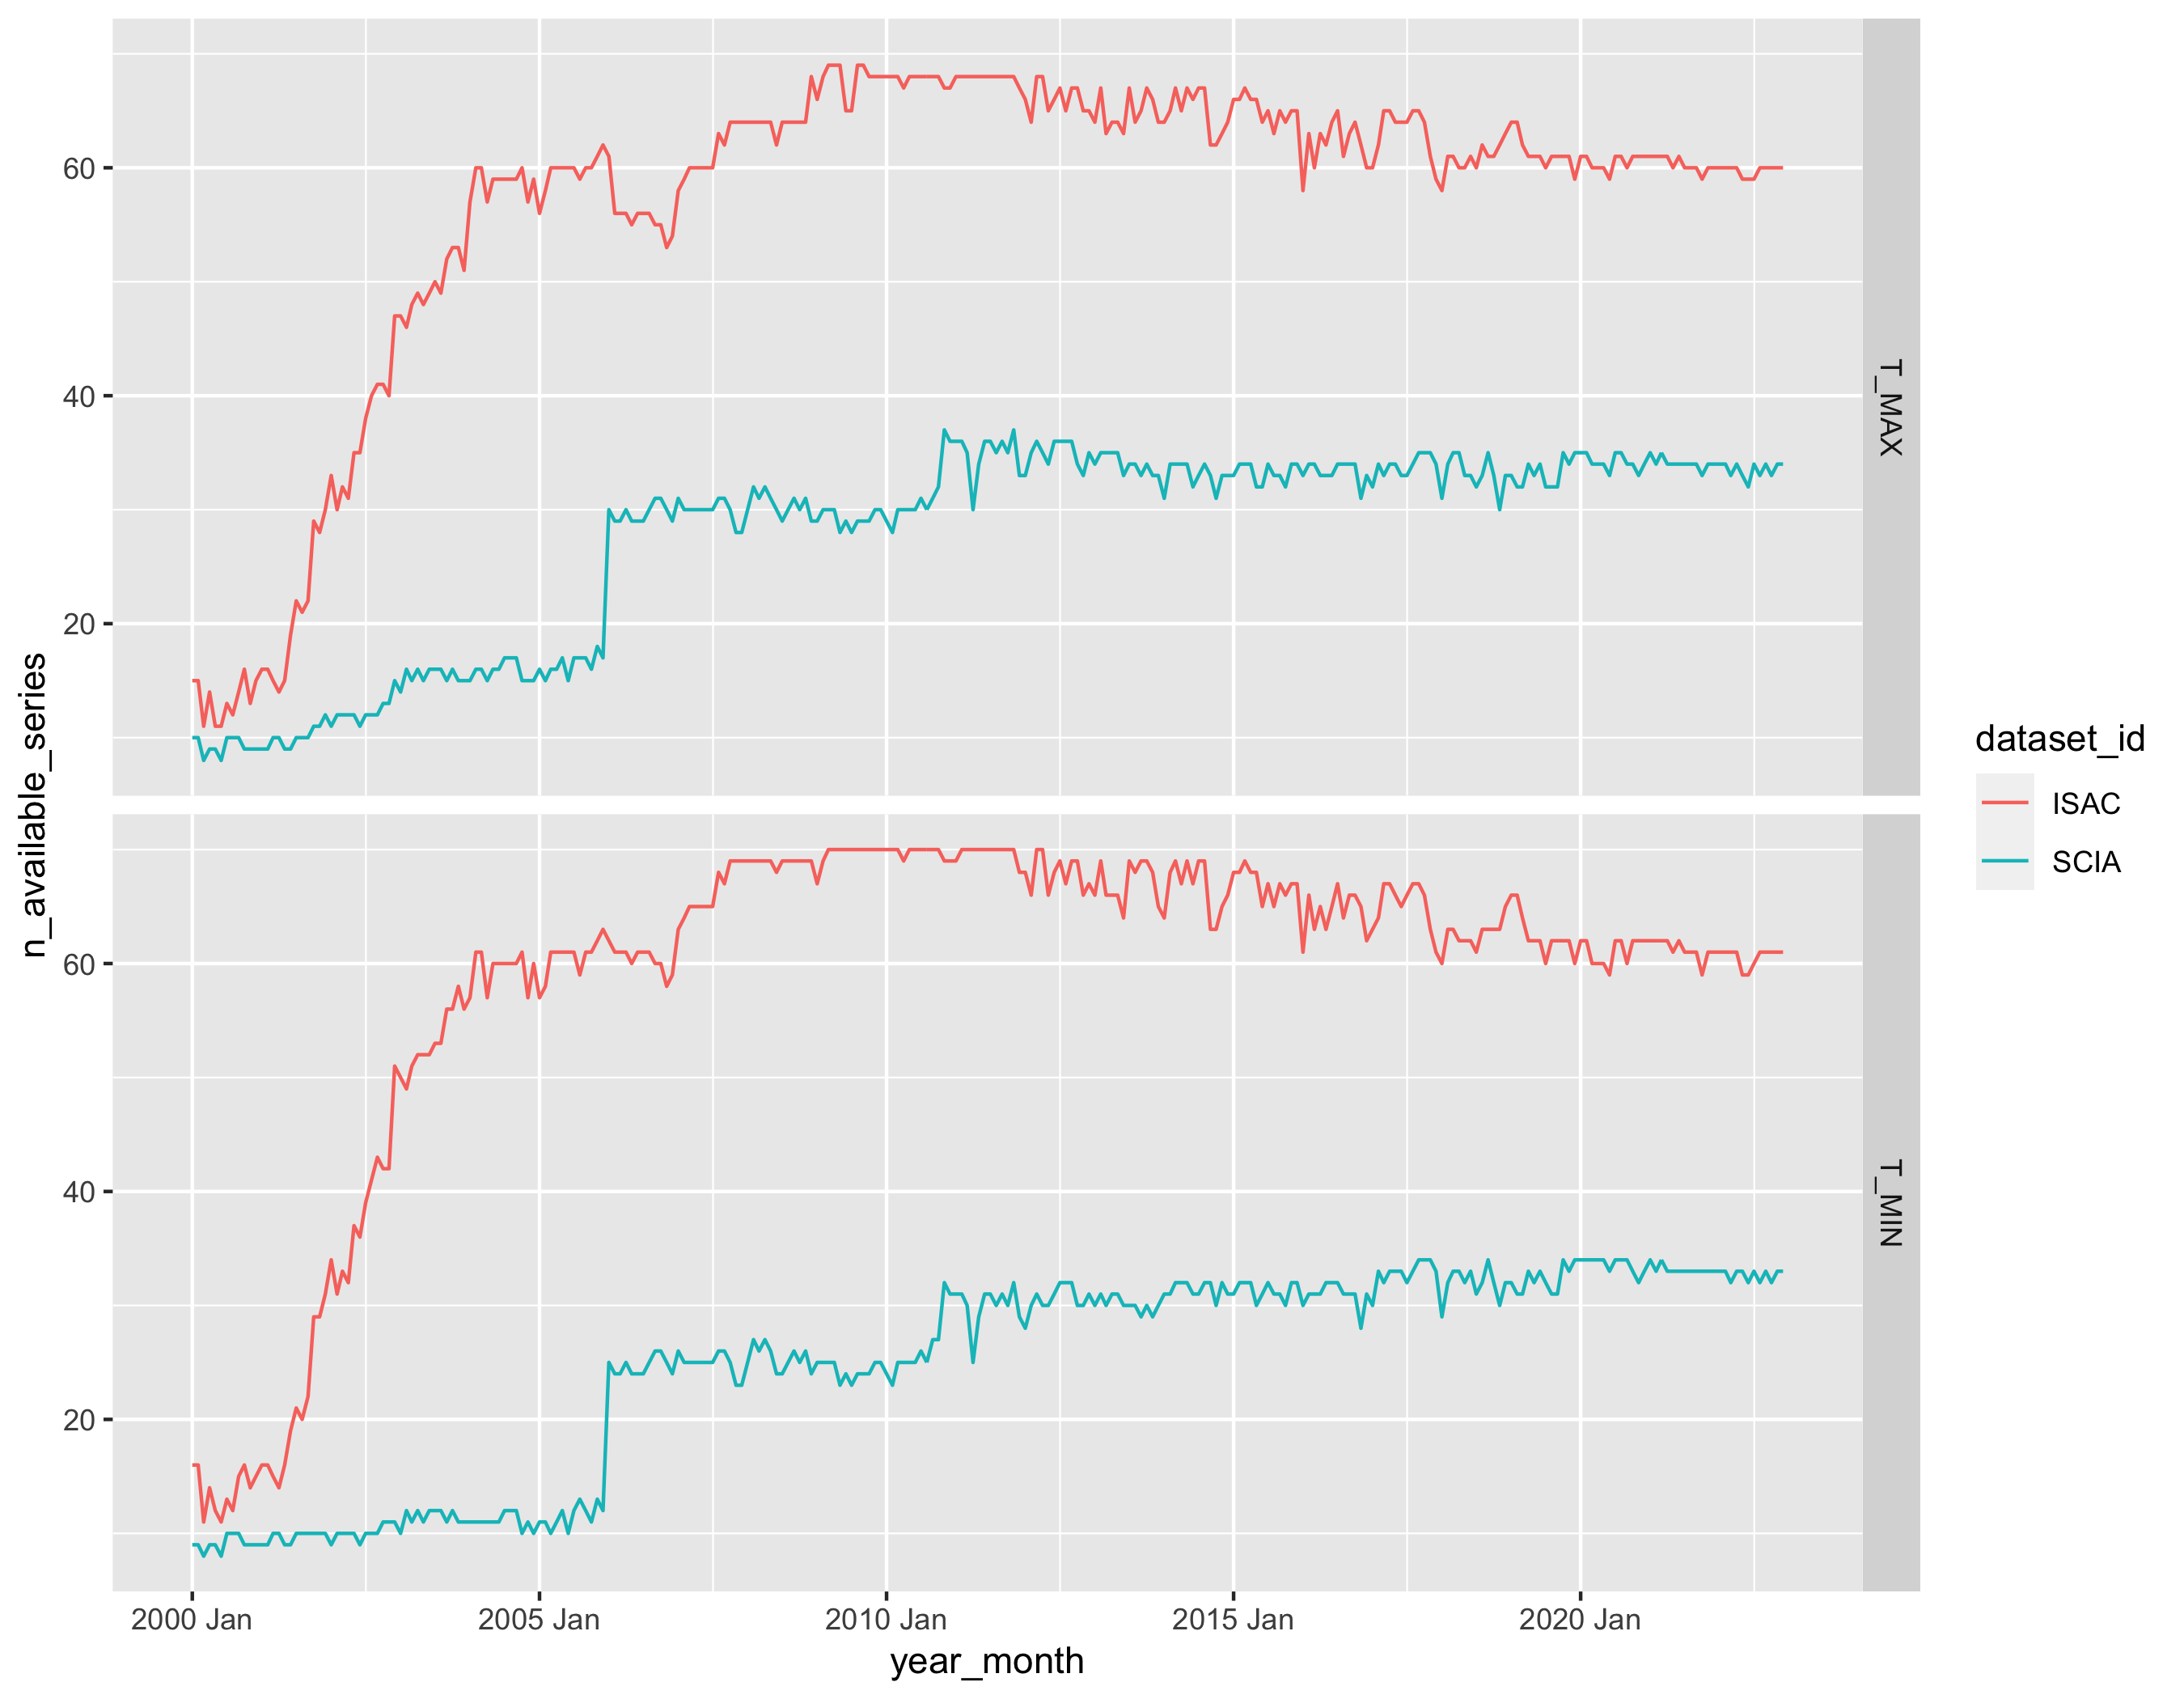

In [9]:
combined_database <- open_checkpoint(dataset_id, "scia_merged")
c(p, ymonthly_avail) %<-% ymonthly_availabilities(combined_database,
    start_date = first_date,
    end_date = last_date
)
p


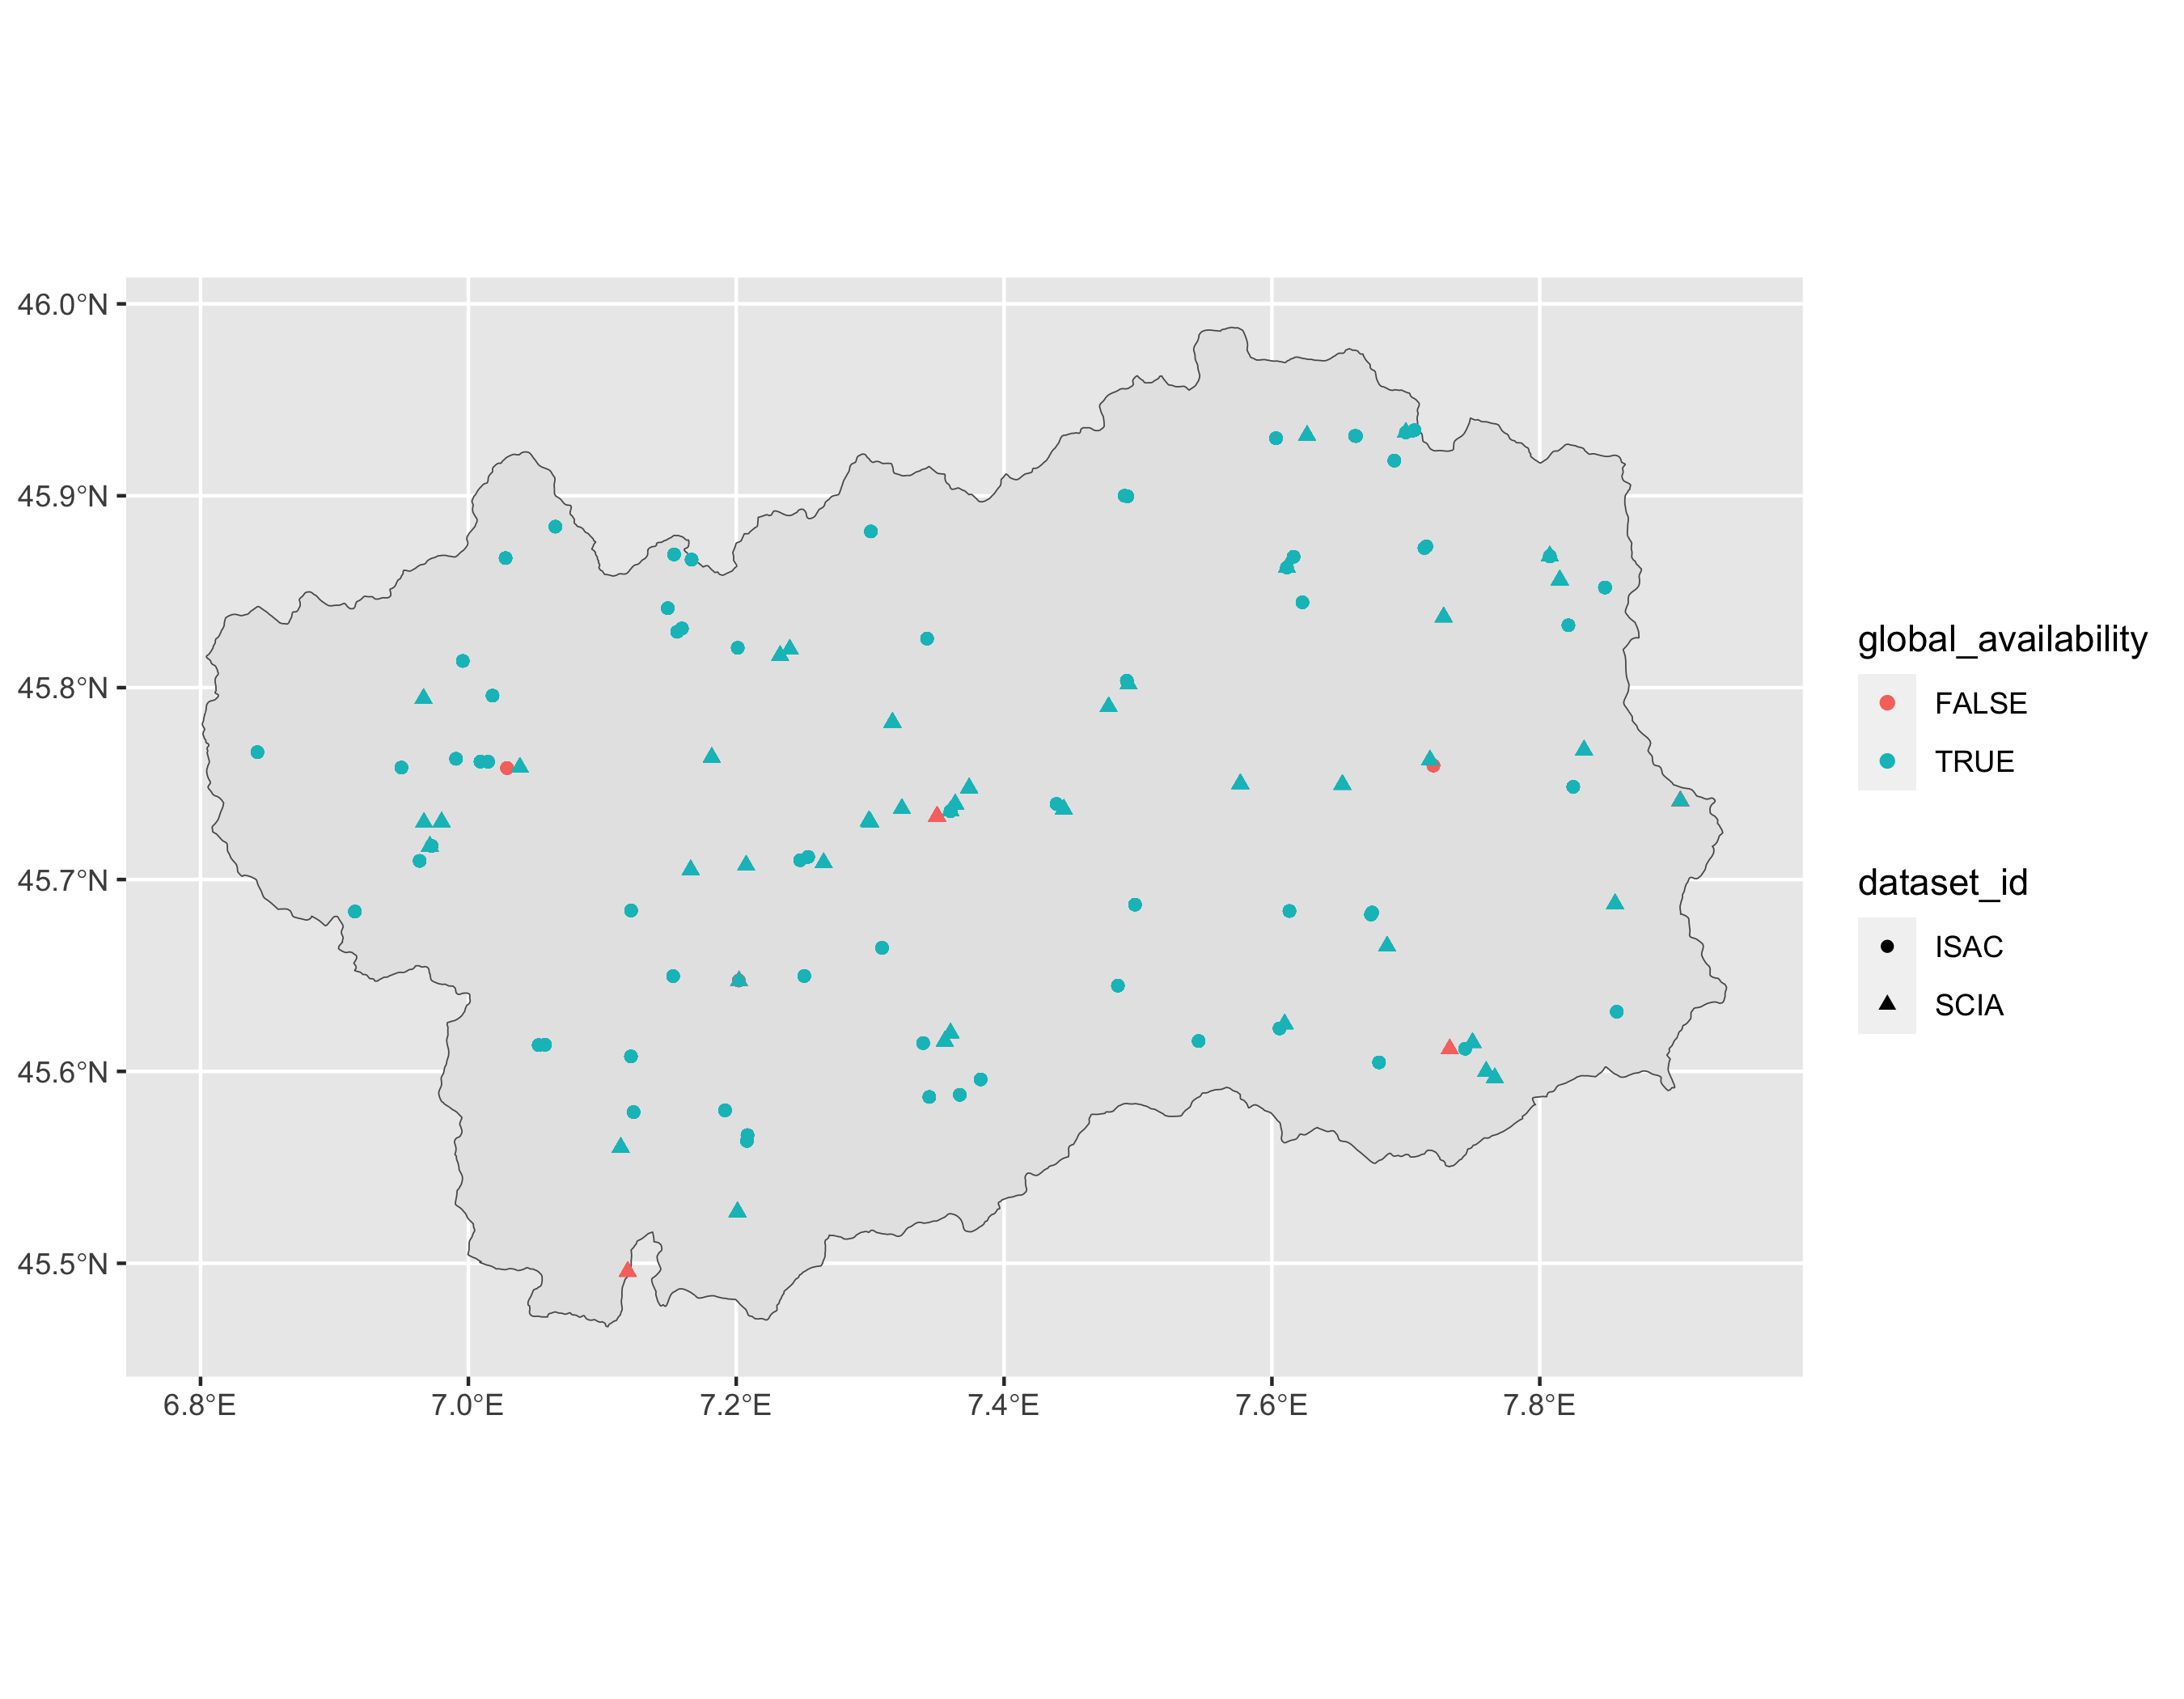

In [10]:
c(p, climats) %<-% spatial_availabilities(ymonthly_avail, combined_database$meta, state_boundaries)
p


In [11]:
rm(ymonthly_avail)
rm(climats)
rm(combination_results)
rm(combined_database)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2253992,120.4,5165330,275.9,NA,5165330,275.9
Vcells,8332140,63.6,189859557,1448.6,16384,296464181,2261.9


### Merge interno

In [12]:
scia_merged <- open_checkpoint(dataset_id, "scia_merged")
analysis_results <- perform_analysis_symmetric(
    scia_merged,
    dist_km = 6,
    first_date,
    last_date,
    file.path("vda", "internal.xlsx"),
    default_symmetric_filter,
    priority_table = NULL,
)

rm(scia_merged)
gc()


Data prepared. Launching analysis...

Warning message:
"There was a problem: some matches were lost. This could be do to matches with empty series"


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2254587,120.5,5165330,275.9,NA,5165330,275.9
Vcells,6127929,46.8,151887646,1158.9,16384,296464181,2261.9


In [13]:
analysis_results <- tag_analysis(analysis_results, list("same_station" = tag_same_station_internal, "unusable" = tag_unusable_internal))
analysis_results$analysis |>
        group_by(same_station, unusable) |>
        tally()
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.x) |>
        tally() |>
        filter(n != 2L & n != 4L)
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.y) |>
        tally() |>
        filter(n != 2L)


same_station,unusable,n
<lgl>,<lgl>,<int>
FALSE,FALSE,66
FALSE,TRUE,308
TRUE,FALSE,26
TRUE,TRUE,8


station_id.x,n
<chr>,<int>
39469c0bfd51b6a43a5a68899b21c39a,1
4c0a3abeaf645966ded1dca89c2a9c98,1
6fc5db8719ca3a83740a339d906d0dad,1
745943eb0cfa2913dab3fef1669c963f,1
7d17eea5b1e2c05aaea07e03a5099adb,1
90420eabcd08df7c4f5e8196b0c68d6b,1
91117e6cef7ba7ec5e43ce9cf9622833,1
a41110bdcdc12a84516a1f1b5e5f32a2,1
d286bb36f4d18db0829722485172a77c,1


station_id.y,n
<chr>,<int>
4c0a3abeaf645966ded1dca89c2a9c98,1
4f3bf1eecce2f0b9732eb29c1b8b4130,1
5d6efabb85a8755d48eddd86606f9522,1
745943eb0cfa2913dab3fef1669c963f,1
76fd13a822ff6e689881dc1019e0305e,1
91117e6cef7ba7ec5e43ce9cf9622833,1
aec25a10e29bf48258fe27fc128dff8b,1
bd7f8166f912795e863f675f6303cf54,1
cf508ca1b93b9fa64d8784b59f51bc82,1


In [14]:
combination_results <- build_combined_database(analysis_results, use_corrections = TRUE, checks = TRUE, test_bounds = 1)
checkpoint_database(combination_results$database, dataset_id, "merged")
save_match_list(combination_results$match_list, dataset_id, "merged")
rm(combination_results)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2255472,120.5,5165330,275.9,NA,5165330,275.9
Vcells,6315351,48.2,121510117,927.1,16384,296464181,2261.9


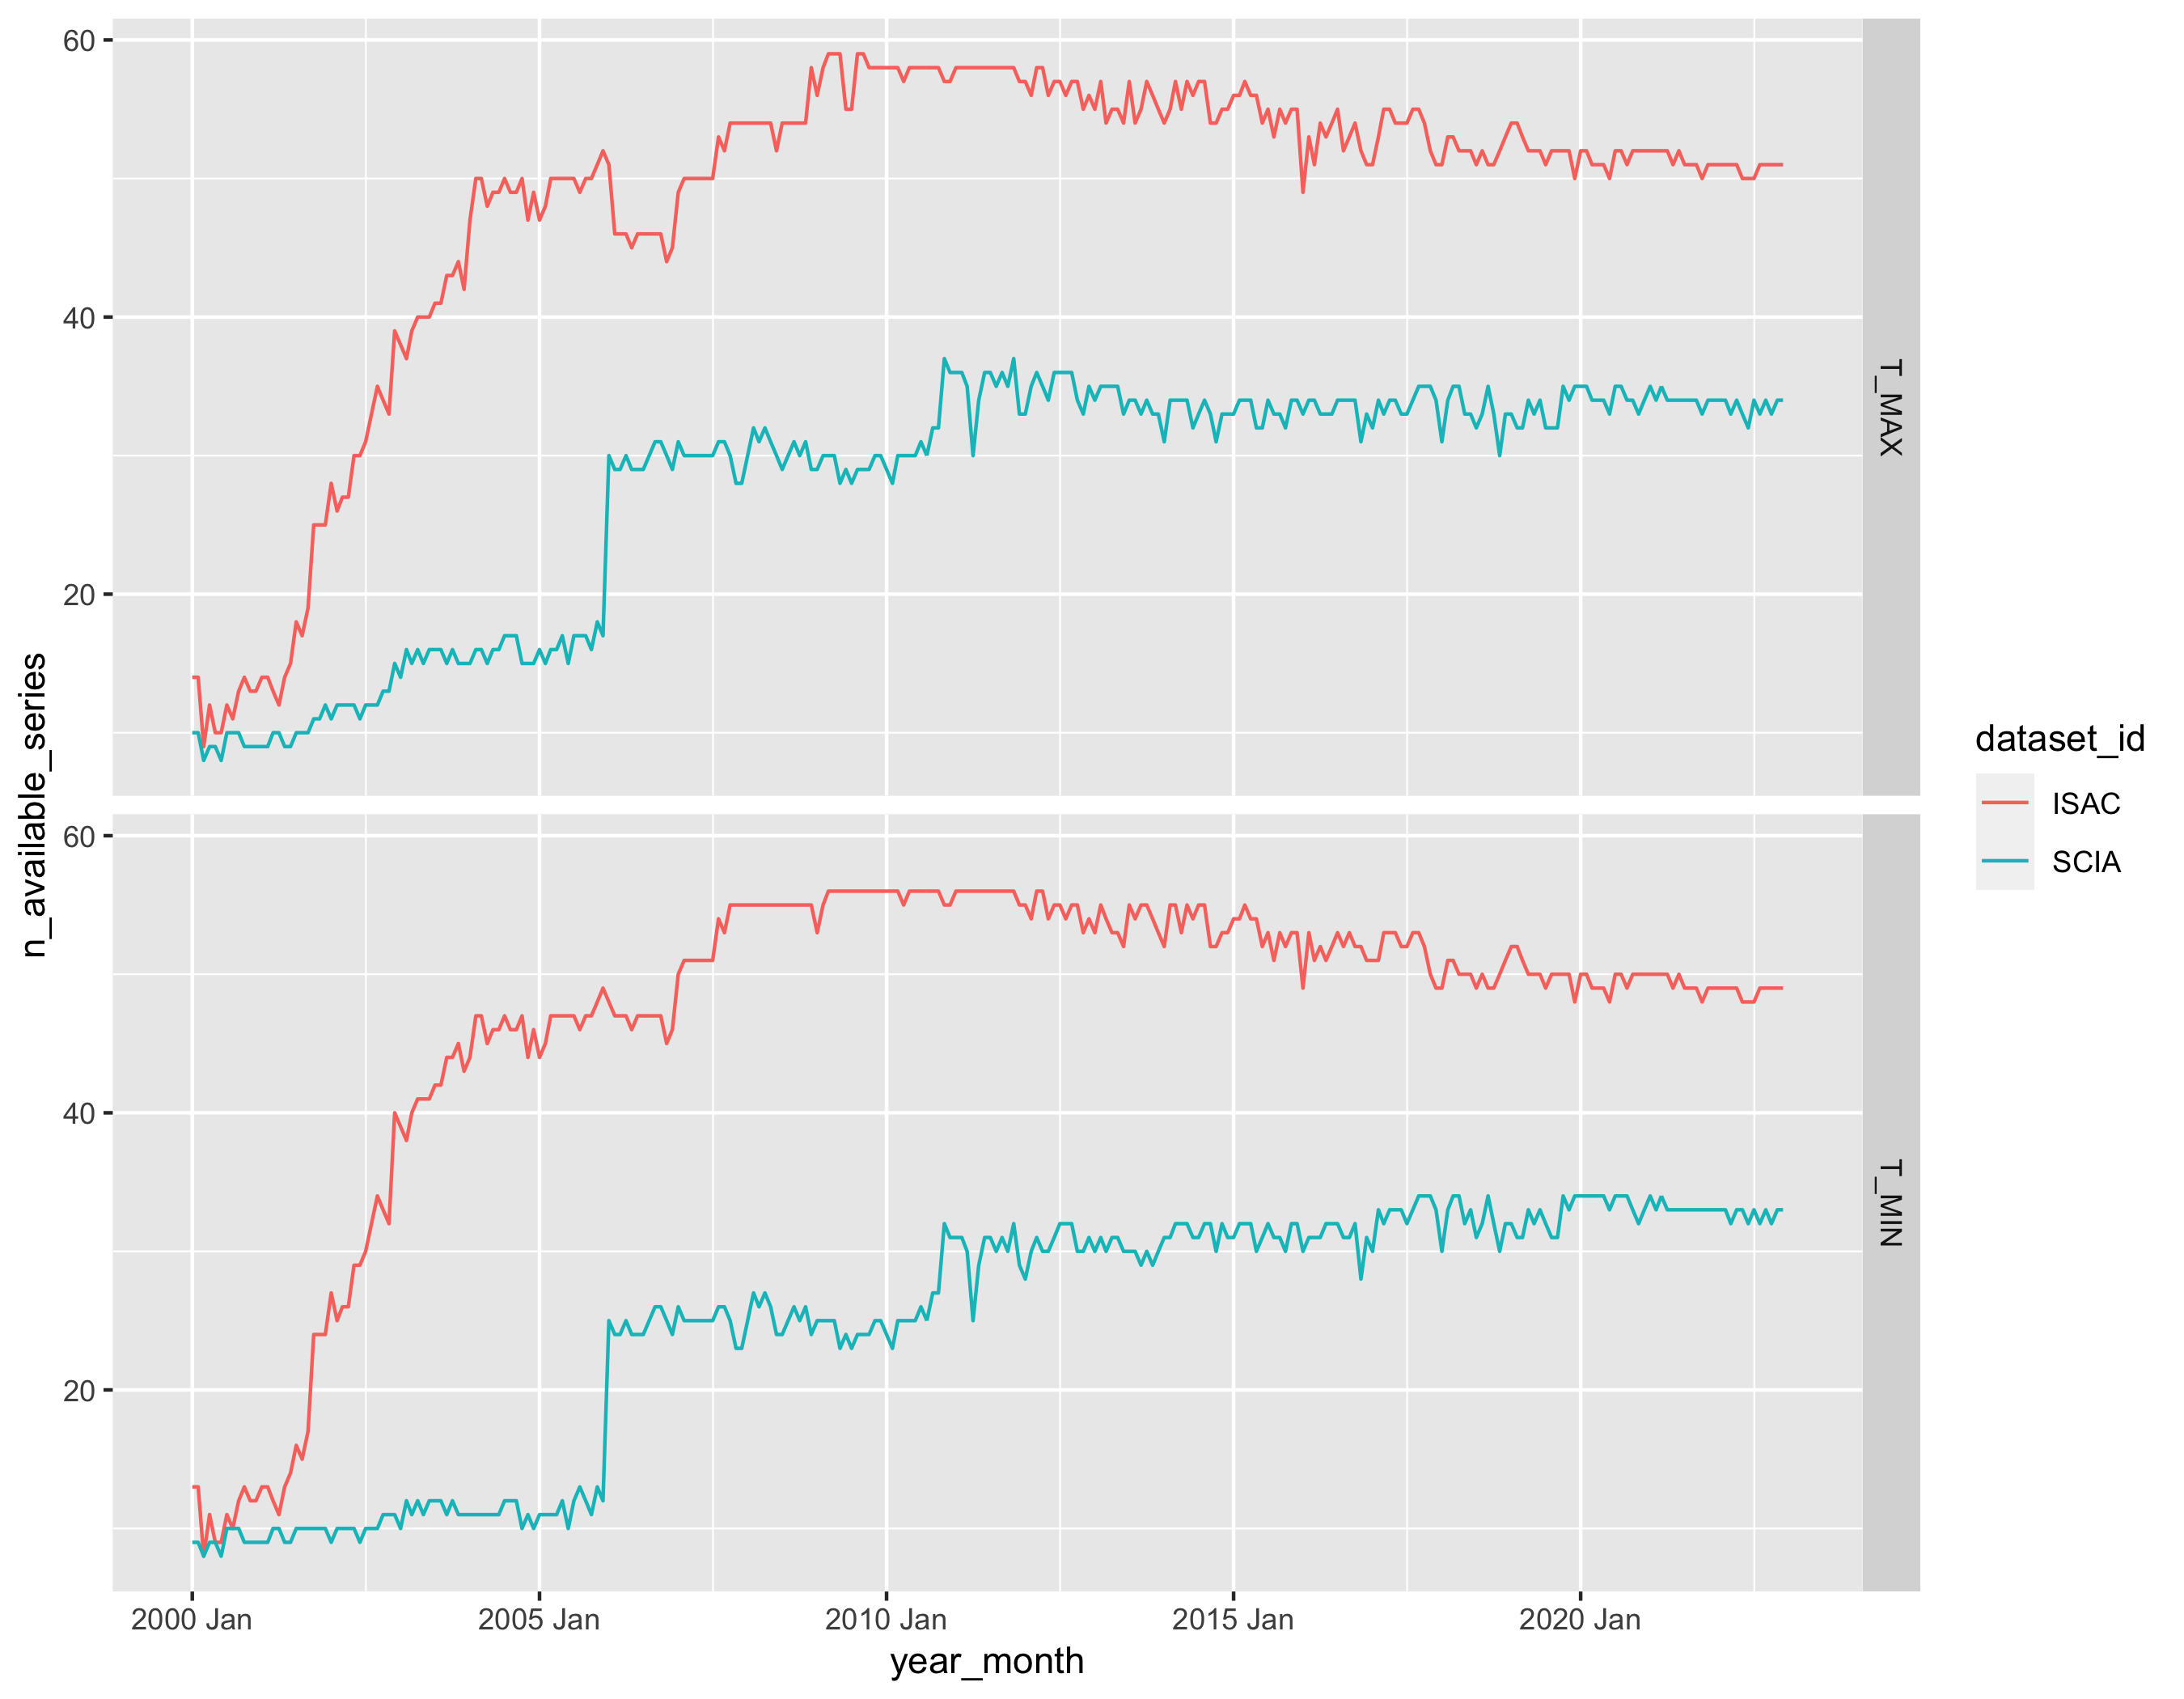

In [15]:
combined_database <- open_checkpoint(dataset_id, "merged")
c(p, ymonthly_avail) %<-% ymonthly_availabilities(combined_database,
    start_date = first_date,
    end_date = last_date
)
p


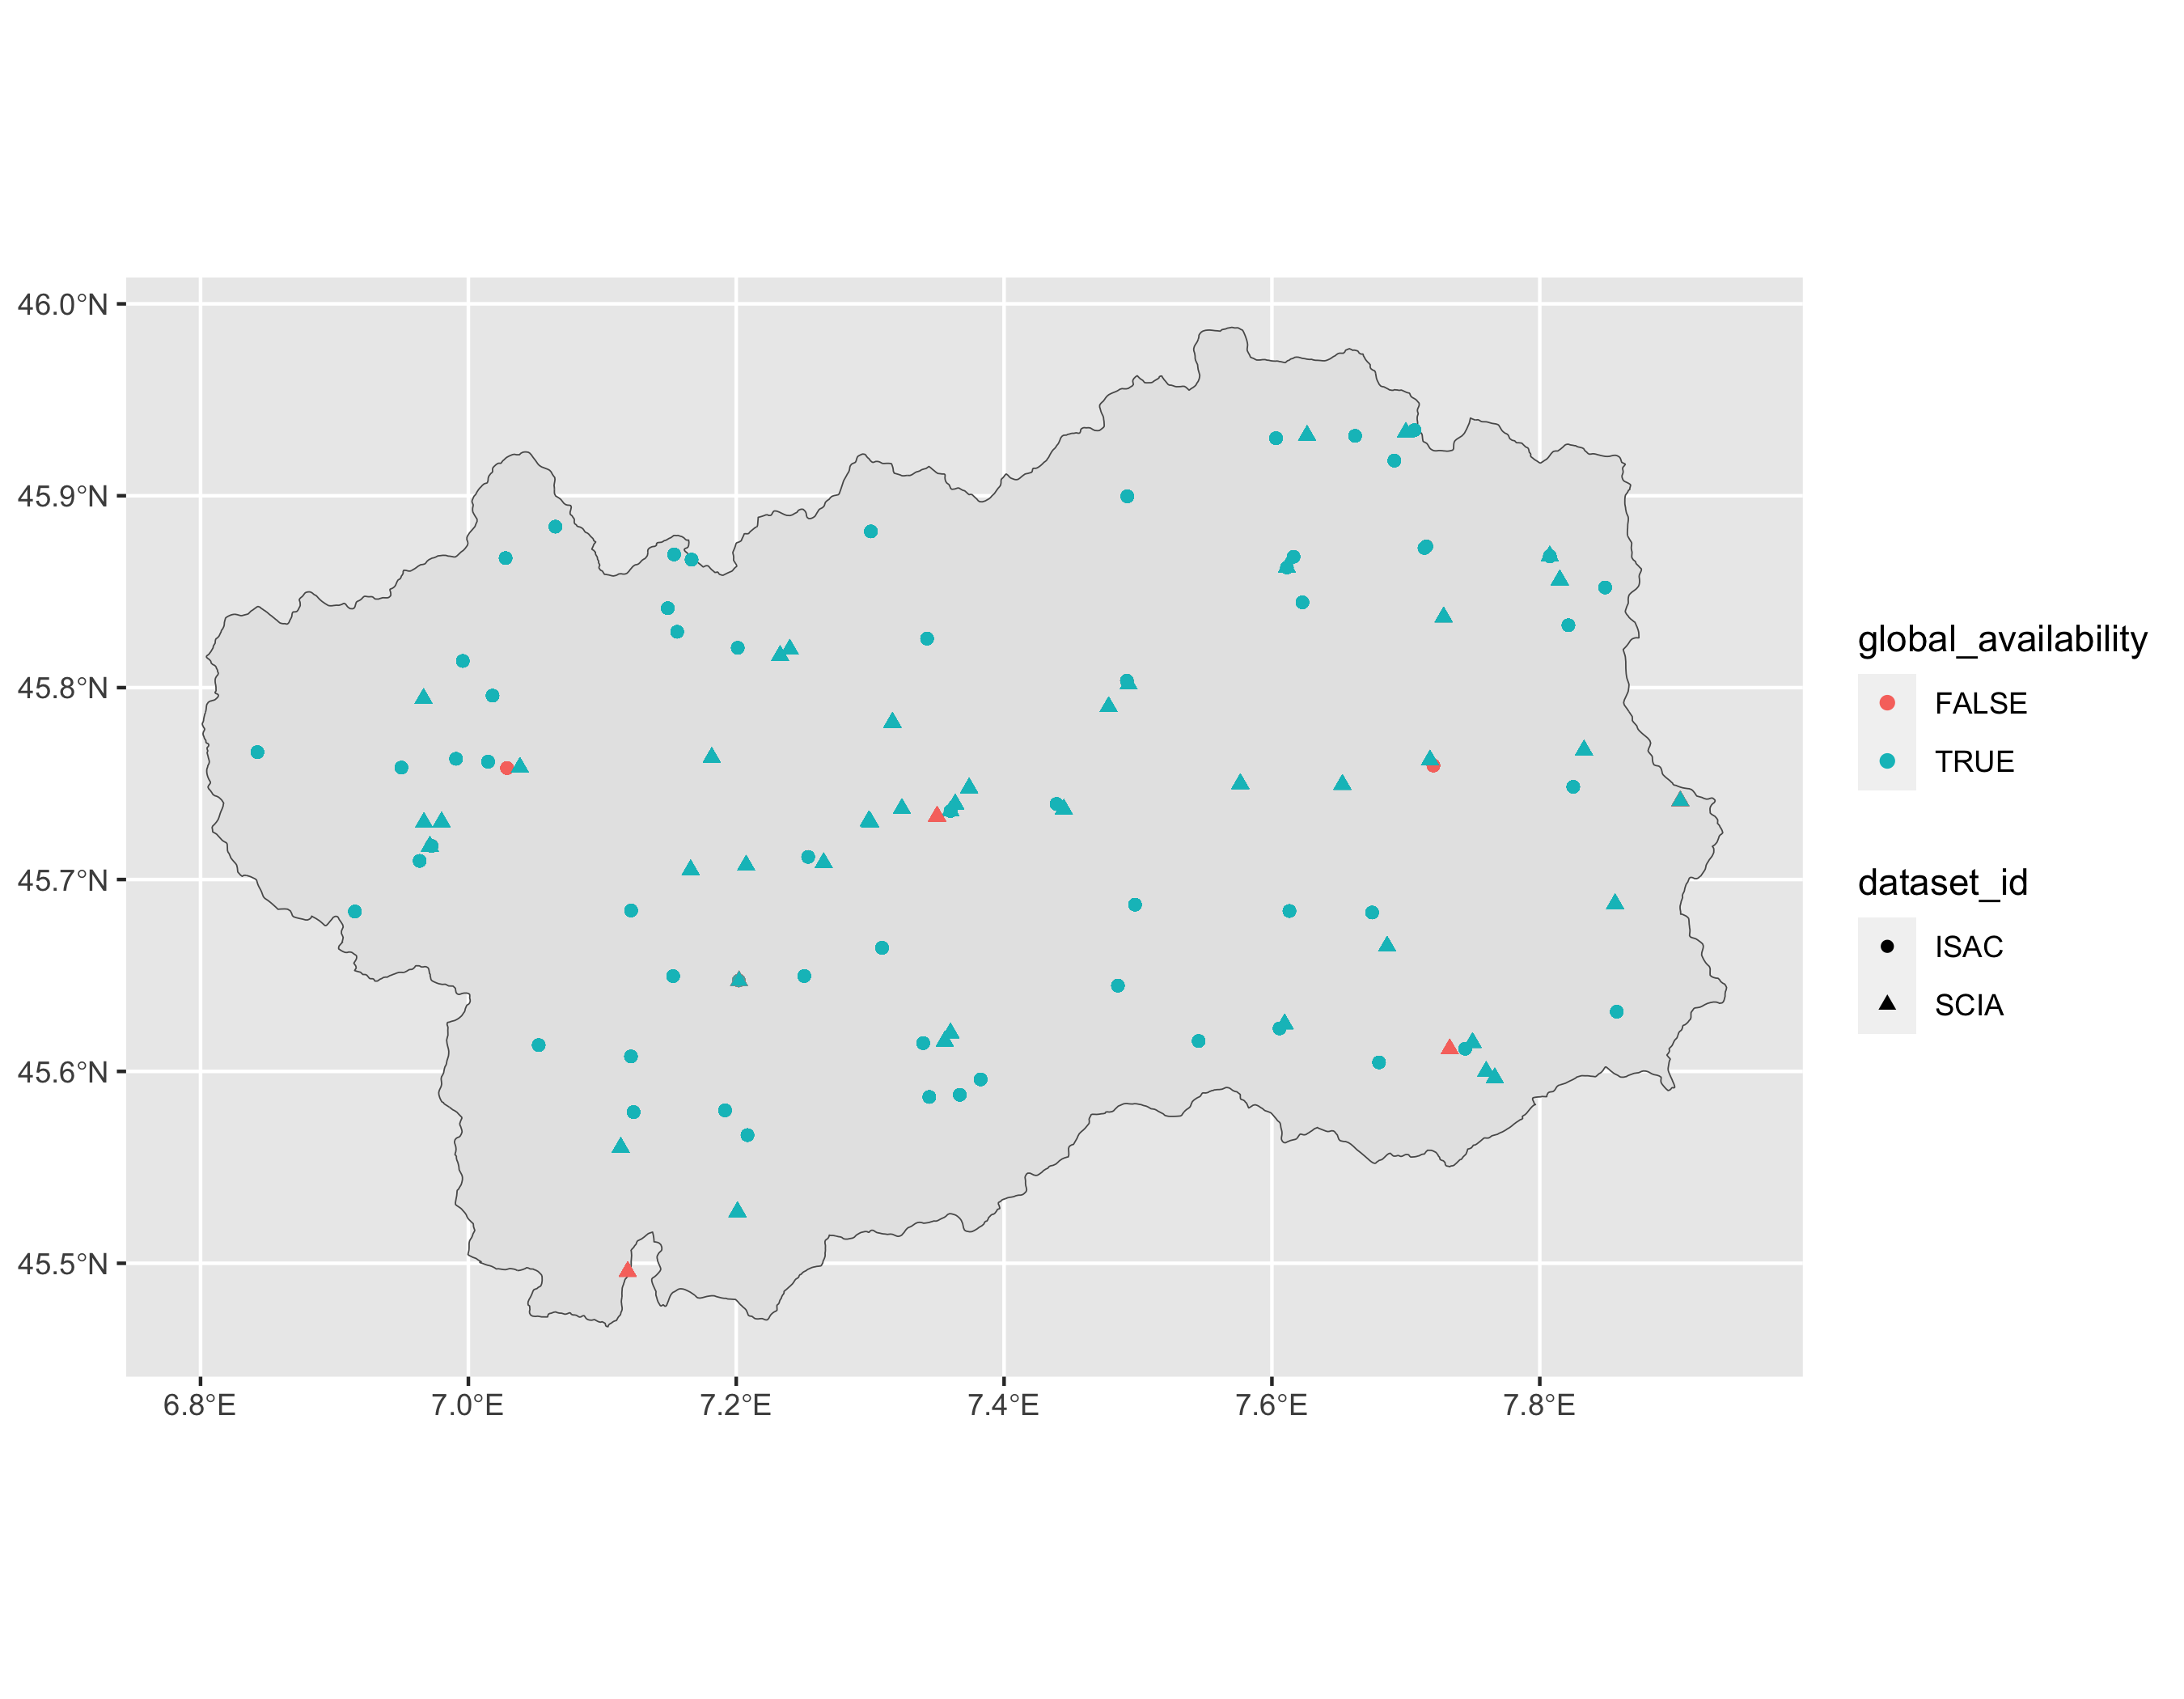

In [16]:
c(p, climats) %<-% spatial_availabilities(ymonthly_avail, combined_database$meta, state_boundaries)
p


In [17]:
print("Available series per variable:")
climats |> as_tibble() |> group_by(variable, station_id) |> summarise(usable = all(clim_available), .groups = "drop_last") |> filter(usable) |> tally()

[1] "Available series per variable:"


variable,n
<chr>,<int>
T_MAX,88
T_MIN,84


In [18]:
rm(ymonthly_avail)
rm(climats)
rm(combined_database)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2254656,120.5,5165330,275.9,NA,5165330,275.9
Vcells,6083844,46.5,97208094,741.7,16384,296464181,2261.9


In [19]:
source("notebooks/integrazioni_regionali/procedure/checkpoint.R")
open_checkpoint(dataset_id, "merged")$data |>
    distinct(station_id, variable) |>
    compute() |>
    nrow()


[1] 194

In [ ]:
# Lanciare da terminale
source("src/pairing/displaying.R")
source("notebooks/integrazioni_regionali/procedure/checkpoint.R")
open_checkpoint(, "merged") |>
    launch_leaflet()
